# Plot PCA on Proteomics data

In [2]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skbio.stats import distance
from sklearn import decomposition, preprocessing

pd.options.mode.copy_on_write = True
pd.options.mode.chained_assignment = None

## Read Data

### LFQ Data

In [3]:
# Read log2-transformed LFQ intensity from shaving data
shaving = pd.read_excel('input_files/20220216_identified_quantified_proteins_shaving.xlsx', #noqa: E501
                   sheet_name = 'quantified_proteins',
                   header = 1)

# Read Z-score abundance from supernatant data
sn = pd.read_excel('input_files/20220428_identified_quantified_supernatant.xlsx',
                   sheet_name = 'quantified_proteins',
                   header = 1)

# Fix stupid names with spaces
shaving.columns = shaving.columns.str.replace(' ', '')
sn.columns = sn.columns.str.replace(' ', '')

shaving = shaving[:-1]
sn = sn[:-1]

### Read Metadata

In [4]:
# Load full protein info
full_sequences = pd.read_csv("input_files/sequences_annotated.csv",
                            index_col = 0)

## Prepare Data

### Define Conditions

In [5]:
# Define Names of timepoints
time_names = ['Mid-log.','End-log.','Late stat.']

# Define Conditions with Shorthand and Timepoints
conditions = {'Fructose': ['F',[10, 14, 20]],
              'Pullulan': ['P',[8,12,20]],
              'Starch': ['S',[8,12,20]],
              'RS': ['resistantS',[5,10,20]]}

# Make list for easier handling
include_columns = []

for _, [shorthand, times] in conditions.items():
     # Iterate over Timepoints
    for t in range(3):

        # Iterate over Replicates
        for i in range(1,4):
            include_columns.append(f'{shorthand}{times[t]}_{i}')

In [6]:
# Let's make a minimal dataframe for comparisons
shaving_min = shaving[['MajorityproteinIDs', *include_columns]]
shaving_min.rename(columns = {"MajorityproteinIDs": 'ProteinIDs'}, inplace = True)

sn_min = sn[['MajorityproteinIDs', *include_columns]]
sn_min.rename(columns = {"MajorityproteinIDs": 'ProteinIDs'}, inplace = True)

# Remove all proteins which weren't detected at all
shaving_min = shaving_min[shaving_min[include_columns].notna().any(axis=1)]
sn_min = sn_min[sn_min[include_columns].notna().any(axis=1)]

### Merge Metadata

In [7]:
shaving_annotated = shaving_min.merge(full_sequences[['SeqID',
                                                 'shortname',
                                                 'amylosome_component']],
                                left_on = 'ProteinIDs',
                                right_on = 'SeqID',
                                how = 'left',
                                validate = '1:m')

sn_annotated = sn_min.merge(full_sequences[['SeqID',
                                                 'shortname',
                                                 'amylosome_component']],
                                left_on = 'ProteinIDs',
                                right_on = 'SeqID',
                                how = 'left',
                                validate = '1:m')

shaving_annotated.amylosome_component = shaving_annotated.amylosome_component.astype('boolean') #noqa: E501
sn_annotated.amylosome_component = sn_annotated.amylosome_component.astype('boolean')

## Make Dataframes

### Impute Values

In [8]:
shaving_imputed = shaving_annotated.copy()
sn_imputed = sn_annotated.copy()

In [9]:
# MinProb: Gaussian sampled around minimum value, with median SD of sample
# Based on the Bioconductor MsCoreUtils::impute_matrix() function

rng = np.random.default_rng(seed = 73) # set seed for reproducibility of plot

for _, [shorthand, times] in conditions.items():

    # Iterate over Sample
    for t in range(3):

        sample_cols = []

        # Iterate over Replicates to get all the names
        for i in range(1,4):
             sample_cols.append(f'{shorthand}{times[t]}_{i}')

        # Get median SD
        sd_sn = sn_annotated[sample_cols].std(axis=1,
                                             ddof=0).median()
        sd_sh = shaving_annotated[sample_cols].std(axis=1,
                                                  ddof=0).median()

        # Iterate over Replicates to perform imputation
        for col in sample_cols:
            min_sn = sn_annotated[col].quantile(0.01)
            min_sh = shaving_annotated[col].quantile(0.01)

            sn_values = rng.normal(loc = min_sn,
                                   scale = sd_sn,
                                   size = sn_annotated[col].isna().sum())

            sh_values = rng.normal(loc = min_sh,
                                   scale = sd_sh,
                                   size = shaving_annotated[col].isna().sum())

            sn_imputed.loc[sn_annotated[col].isna(), col] = sn_values
            shaving_imputed.loc[shaving_annotated[col].isna(), col] = sh_values

shaving_identified_all = shaving_imputed
sn_identified_all = sn_imputed

### Assemble DataFrame

In [10]:
# Dataframe for all Dockerin- or Cohesin-containing proteins
shaving_amylosome = shaving_identified_all[
                        shaving_identified_all.amylosome_component]

sn_amylosome = sn_identified_all[
                        sn_identified_all.amylosome_component]

# Dataframe for Results
df = pd.DataFrame(columns = ['Carb',
                             'Time_h',
                             'Timepoint',
                             'shaving_all',
                             'shaving_amylosome',
                             'sn_all',
                             'sn_amylosome',
                             'replicate',
                            ])

# Iterate over Carbon Sources
for carb, [shorthand, times] in conditions.items():

    # Iterate over Timepoints
    for t in range(3):

        # Iterate over Replicates
        for i in range(1,4):
            col_name = f'{shorthand}{times[t]}_{i}'

            temp = {'Carb': carb,
                    'Time_h': times[t],
                    'Timepoint': time_names[t],
                    'shaving_all': shaving_identified_all[col_name].values,
                    'shaving_amylosome': shaving_amylosome[col_name].values,
                    'sn_all': sn_identified_all[col_name].values,
                    'sn_amylosome': sn_amylosome[col_name].values,
                    'replicate': i,
                    }

            df.loc[len(df)] = temp

## Calculate

### PCA

In [11]:
scaling = preprocessing.StandardScaler()
pca = decomposition.PCA(n_components=2,
                       svd_solver = "full",
                       whiten = True,
                       random_state = 73)

result_df = pd.DataFrame(columns = ['Sample',
                                    'Carb',
                                    'Time',
                                    'Coordinates',
                                    'Explained_Variance_PC1',
                                    'Explained_Variance_PC2',
                                    ])

for sample in ["shaving_all",
               "shaving_amylosome",
               "sn_all",
               "sn_amylosome"]:

    # Scale
    scaled_temp = scaling.fit_transform(np.stack(df[sample]))

    # Calculate PCA for all proteins
    pca_temp = pca.fit(scaled_temp)

    temp = {'Sample': sample,
            'Carb': df.Carb,
            'Time': df.Timepoint,
            'Coordinates': pca_temp.transform(scaled_temp),
            'Explained_Variance_PC1': pca_temp.explained_variance_ratio_[0],
            'Explained_Variance_PC2': pca_temp.explained_variance_ratio_[1],
            }

    result_df.loc[len(result_df)] = temp


#### Calculate ANOSIM

##### Cell-associated

In [12]:
scaling = preprocessing.StandardScaler()

sample = "shaving_amylosome"

# Scale
scaled_temp = scaling.fit_transform(np.stack(df[sample]))

scales = pd.DataFrame(data = scaled_temp.T,
                      columns = include_columns)

distance_df = pd.DataFrame(columns = include_columns,
                        dtype=float)

# Calculate Euclidean Distance for each sample for each combination of conditions
for col_a, col_b in itertools.combinations(include_columns, 2):

    dist_all = np.linalg.norm(scales[col_a] - scales[col_b])

    distance_df.loc[col_a, col_b] = dist_all
    distance_df.loc[col_b, col_a] = dist_all

#   Fill Diagonal Line
distance_df = distance_df.fillna(0)

distance_matrix = distance.DistanceMatrix(data = distance_df.copy(),
                                          ids=distance_df.columns)

# Calculate ANOSIM
distance.anosim(distance_matrix,
                grouping = result_df.loc[0, "Carb"].values,
                permutations = 10000)

method name                 ANOSIM
test statistic name              R
sample size                     36
number of groups                 4
test statistic            0.651006
p-value                     0.0001
number of permutations       10000
Name: ANOSIM results, dtype: object

##### Supernatant

In [14]:
scaling = preprocessing.StandardScaler()

sample = "sn_amylosome"

# Scale
scaled_temp = scaling.fit_transform(np.stack(df[sample]))

scales = pd.DataFrame(data = scaled_temp.T,
                      columns = include_columns)

distance_df = pd.DataFrame(columns = include_columns,
                        dtype=float)

# Calculate Euclidean Distance for each sample for each combination of conditions
for col_a, col_b in itertools.combinations(include_columns, 2):

    dist_all = np.linalg.norm(scales[col_a] - scales[col_b])

    distance_df.loc[col_a, col_b] = dist_all
    distance_df.loc[col_b, col_a] = dist_all

#   Fill Diagonal Line
distance_df = distance_df.fillna(0)

distance_matrix = distance.DistanceMatrix(data = distance_df.copy(),
                                          ids=distance_df.columns)

# Calculate ANOSIM
distance.anosim(distance_matrix,
                grouping = result_df.loc[0, "Carb"].values,
                permutations = 10000)

method name                 ANOSIM
test statistic name              R
sample size                     36
number of groups                 4
test statistic            0.541638
p-value                     0.0001
number of permutations       10000
Name: ANOSIM results, dtype: object

## Plot

In [15]:
# Carb Palette defined based on ColorBrewer 5-class BrBG
carb_palette = {"Pullulan": "#a6611a",
                "Fructose": "#969696",
                "Starch": "#80cdc1",
                "RS": "#018571",
                }

### Diagnostic Overview

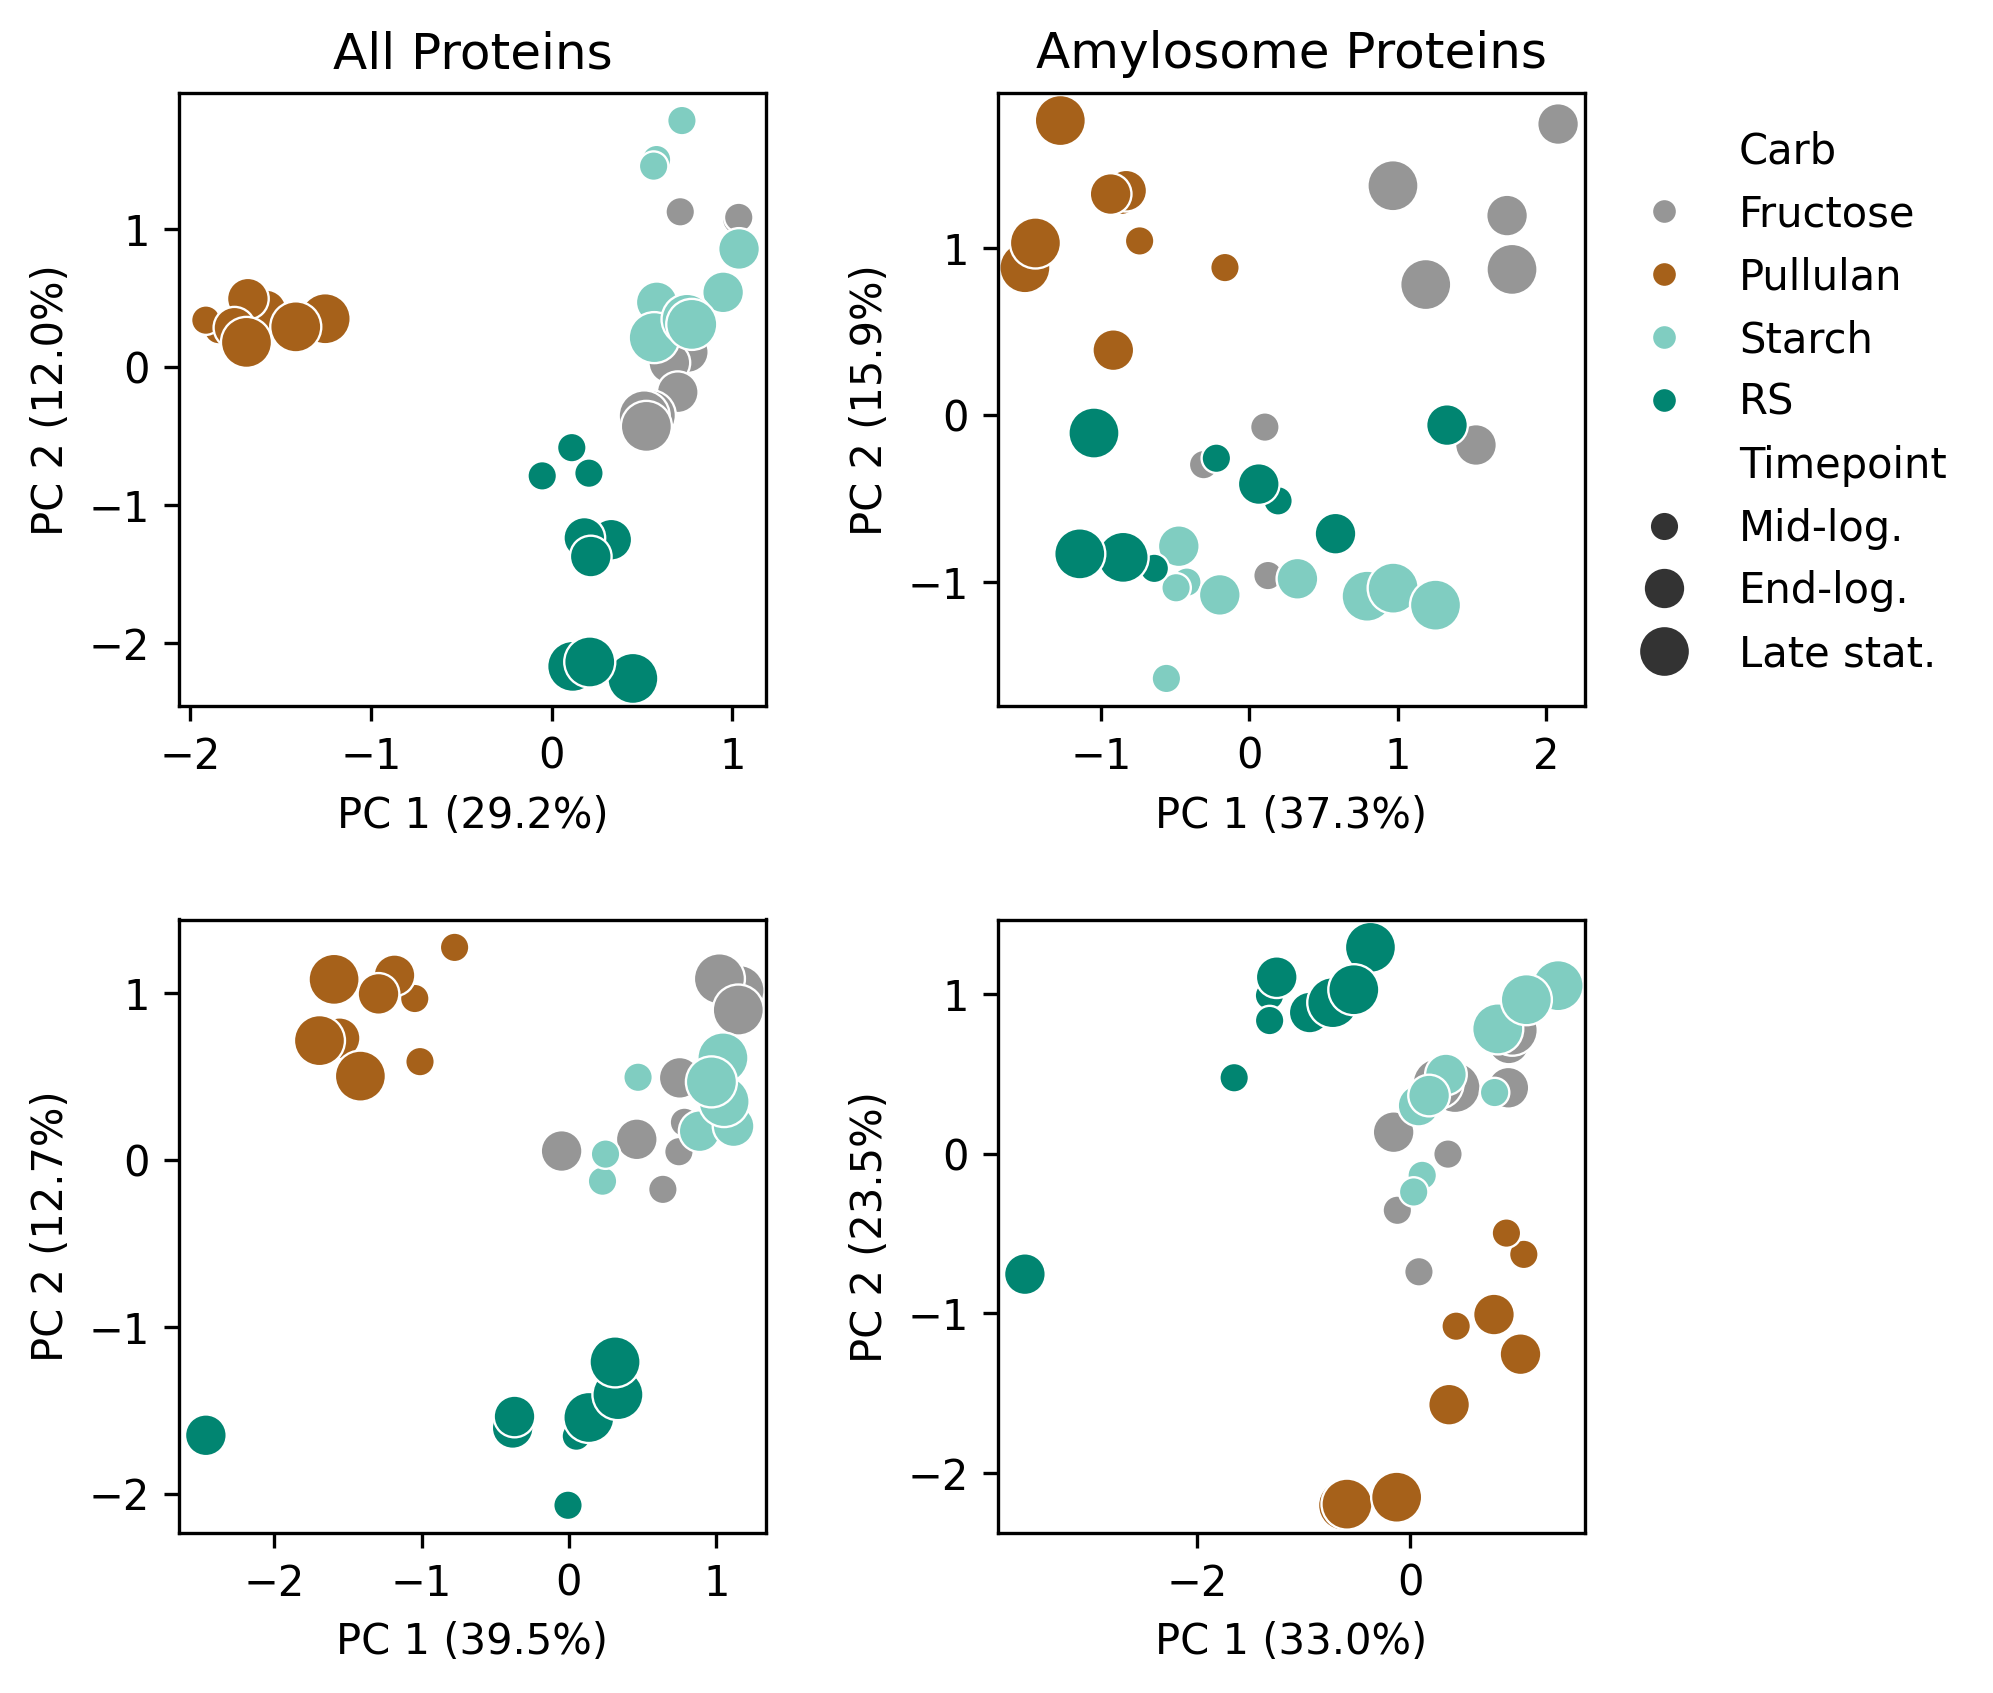

In [16]:
figure, axis = plt.subplots(nrows= 2,
                            ncols = 2,
                            dpi=300,
                            figsize=(7,6),
                            sharex = False,
                            sharey = False)

for index, row in result_df.iterrows():

    pos = (int(index/2), index%2)

    sns.scatterplot(x = row["Coordinates"][:,0],
                    y = row["Coordinates"][:,1],
                    hue = row["Carb"],
                    size = row["Time"],
                    sizes = {'Mid-log.': 50,
                            'End-log.': 100,
                            'Late stat.': 150},
                    palette = carb_palette,
                    ax = axis[pos],
                    legend = (pos == (0,1)),
                    )

    axis[pos].set_xlabel(f'PC 1 ({row["Explained_Variance_PC1"]*100:.1f}%)')
    axis[pos].set_ylabel(f'PC 2 ({row["Explained_Variance_PC2"]*100:.1f}%)')

axis[0,0].set_title("All Proteins")
axis[0,1].set_title("Amylosome Proteins")

sns.move_legend(axis[0,1],
                'upper left',
                bbox_to_anchor=(1,1),
                frameon = False)

figure.tight_layout(pad = 2)


#### Export for Figure 2

/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18611/3682891875.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = ax.get_xticklabels(),
/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18611/3682891875.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels = ax.get_yticklabels(),


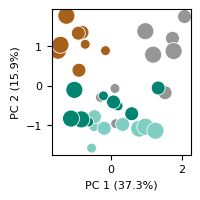

In [17]:
inch = 2.54 # one inch is 2.54 cm

row = result_df.loc[result_df.Sample == "shaving_amylosome"].squeeze()

fig, ax = plt.subplots(figsize=(5.3 / inch,
                                5.3 / inch))

sns.scatterplot(x = row["Coordinates"][:,0],
                y = row["Coordinates"][:,1],
                hue = row["Carb"],
                size = row["Time"],
                sizes = {'Mid-log.': 50,
                            'End-log.': 100,
                            'Late stat.': 150},
                palette = carb_palette,
                ax = ax,
                legend = False)

ax.set_xlabel(f'PC 1 ({row["Explained_Variance_PC1"]*100:.1f}%)',
              fontsize = 8)
ax.set_xticklabels(labels = ax.get_xticklabels(),
                   fontsize = 8,)
ax.set_ylabel(f'PC 2 ({row["Explained_Variance_PC2"]*100:.1f}%)',
              fontsize = 8)
ax.set_yticklabels(labels = ax.get_yticklabels(),
                   fontsize = 8)

fig.tight_layout(pad=1)

#### Export for Supplementary Fig. 4

/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18611/4265720814.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = ax.get_xticklabels(),
/var/folders/l7/1b9_62652nz78xwxxmb1knm80000gn/T/ipykernel_18611/4265720814.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels = ax.get_yticklabels(),


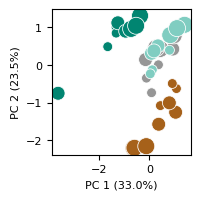

In [19]:
inch = 2.54 # one inch is 2.54 cm

row = result_df.loc[result_df.Sample == "sn_amylosome"].squeeze()

fig, ax = plt.subplots(figsize=(5.3 / inch,
                                5.3 / inch))

sns.scatterplot(x = row["Coordinates"][:,0],
                y = row["Coordinates"][:,1],
                hue = row["Carb"],
                size = row["Time"],
                sizes = {'Mid-log.': 50,
                            'End-log.': 100,
                            'Late stat.': 150},
                palette = carb_palette,
                ax = ax,
                legend = False)

ax.set_xlabel(f'PC 1 ({row["Explained_Variance_PC1"]*100:.1f}%)',
              fontsize = 8)
ax.set_xticklabels(labels = ax.get_xticklabels(),
                   fontsize = 8,)
ax.set_ylabel(f'PC 2 ({row["Explained_Variance_PC2"]*100:.1f}%)',
              fontsize = 8)
ax.set_yticklabels(labels = ax.get_yticklabels(),
                   fontsize = 8)

fig.tight_layout(pad=1)